In [0]:
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
### Doing Data Augmentation
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 128, shuffle=False)

0it [00:00, ?it/s]

170500096it [00:06, 27427416.38it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

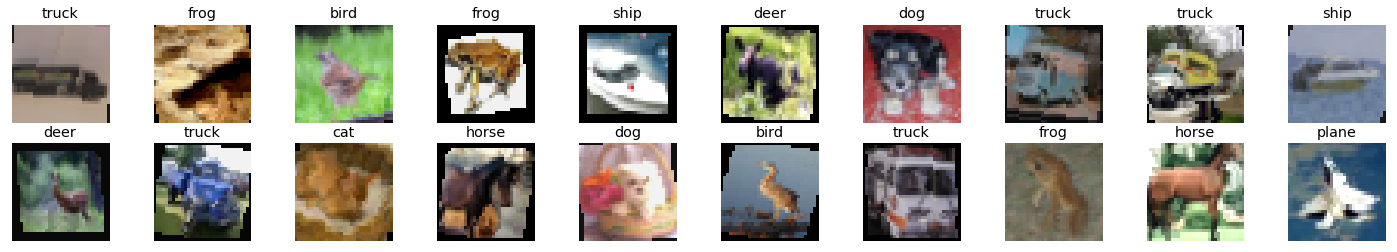

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
class LeNet(nn.Module):

    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) ## The image starts as 32*32
      self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) ## After first max_pool layer, it becomes 16*16
      self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) ## After second max_pool layer, it becomes 8*8
      self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) ## After third max_pool layer, it becomes 4*4. And after 4th, it becomes 2*2 and so on.
      
      self.fc1 = nn.Linear(2*2*128, 800)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(800, 10)

    def forward(self, x):
          """Feed forward network"""
          x = F.relu(self.conv1(x))
          x = F.max_pool2d(x, 2, 2) ## 16*16
          x = F.relu(self.conv2(x))
          x = F.max_pool2d(x, 2, 2) ## 8*8
          x = F.relu(self.conv3(x))
          x = F.max_pool2d(x, 2, 2) ## 4*4
          x = F.relu(self.conv4(x))
          x = F.max_pool2d(x, 2, 2) ## 2*2

          x = x.view(-1, 2*2*128)
          x = F.relu(self.fc1(x))
          
          x = self.dropout1(x)
          x = self.fc2(x)
          return x

In [8]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=800, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=800, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [10]:
epochs = 40
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.7353, acc 45.7238 
validation loss: 1.4112, validation acc 60.5443 
epoch : 2
training loss: 1.3766, acc 63.8184 
validation loss: 1.1989, validation acc 71.2785 
epoch : 3
training loss: 1.2293, acc 71.4476 
validation loss: 1.0943, validation acc 76.2785 
epoch : 4
training loss: 1.1300, acc 76.5601 
validation loss: 1.0140, validation acc 81.3038 
epoch : 5
training loss: 1.0500, acc 80.0256 
validation loss: 0.9551, validation acc 83.9873 
epoch : 6
training loss: 0.9971, acc 82.5038 
validation loss: 0.9577, validation acc 84.1266 
epoch : 7
training loss: 0.9633, acc 84.4169 
validation loss: 0.8862, validation acc 87.3165 
epoch : 8
training loss: 0.9256, acc 86.2711 
validation loss: 0.8358, validation acc 89.6456 
epoch : 9
training loss: 0.8929, acc 87.9693 
validation loss: 0.8142, validation acc 90.5316 
epoch : 10
training loss: 0.8576, acc 89.3120 
validation loss: 0.7800, validation acc 92.0000 
epoch : 11
training loss: 0.8395, acc 90.1151 
va

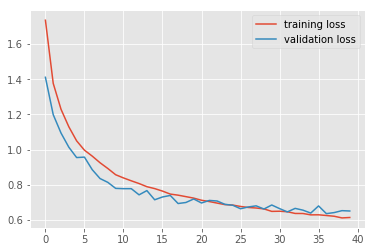

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

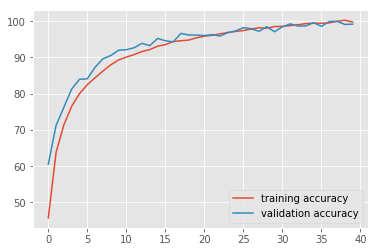

In [12]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [13]:
!pip3 install pillow==4.0.0

     |████████████████████████████████| 5.6MB 6.6MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


In [0]:
import PIL.ImageOps

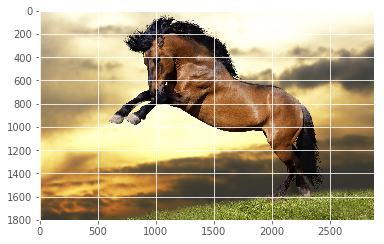

In [15]:
import requests
from PIL import Image

url = 'http://wallpapersite.com/images/wallpapers/jumping-horse-2880x1800-strong-horse-hd-3000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

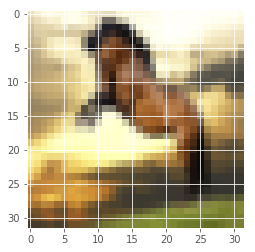

In [16]:
img = transform(img) 
plt.imshow(im_convert(img))

In [17]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

horse


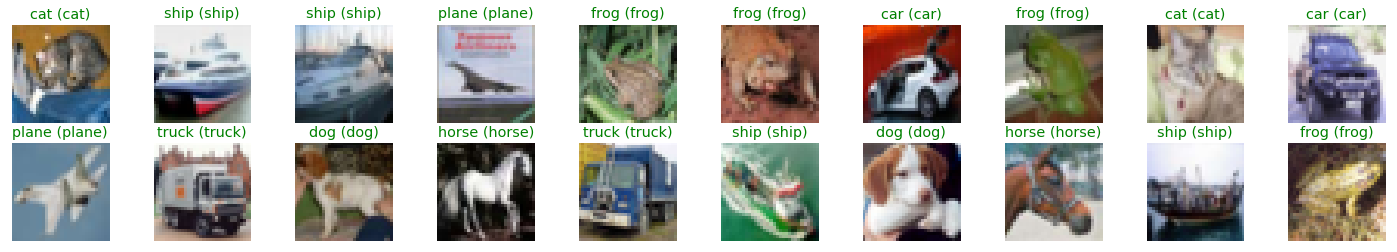

In [18]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))